In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.utils import check_random_state

from dataset import generate_synthetic_data
from policylearners import (
    RegBasedPolicyLearner,
    GradientBasedPolicyLearner,
    POCEM,
)
from utils import softmax


## g関数の精度を変更

In [8]:
## 実験設定
num_runs = 5
dim_x = 5
num_data = 4000
num_actions = 2000
num_clusters = 30
lambda_ = 0.5
random_state = 12345
beta = 1
sigma = 2
max_iter = 30
torch.manual_seed(random_state)
random_ = check_random_state(random_state)

sigma_h = 0.0
sigma_g_list = [0.0, 0.5, 1.0, 1.5, 2.0]


In [9]:
phi_a = random_.choice(num_clusters, size=num_actions)
theta_g = random_.normal(size=(dim_x, num_clusters))
M_g = random_.normal(size=(dim_x, num_clusters))
b_g = random_.normal(size=(1, num_clusters))
theta_h = random_.normal(size=(dim_x, num_actions))
M_h = random_.normal(size=(dim_x, num_actions))
b_h = random_.normal(size=(1, num_actions))
dataset_test = generate_synthetic_data(
    num_data=10000, lambda_=lambda_, beta=beta, sigma=sigma,
    theta_g=theta_g, M_g=M_g, b_g=b_g,
    theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
    dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters, random_state = random_state
)
pi_0_value = (dataset_test["q_x_a"] * dataset_test["pi_0"]).sum(1).mean()

result_df_list = []
for sigma_g in sigma_g_list:
    test_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"sigma_g={sigma_g}..."):
        dataset = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_, beta=beta, sigma=sigma,
            theta_g=theta_g, M_g=M_g, b_g=b_g,
            theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters,
            random_state = _
        )

        true_value_of_learned_policies = dict()

        true_value_of_learned_policies["logging"] = pi_0_value

        eps_h = random_.laplace(scale=sigma_h, size=(1, num_actions))
        eps_g = random_.laplace(scale=sigma_g, size=(1, num_clusters))
        f_hat = dataset["q_x_a"] + eps_g[:, phi_a[np.arange(num_actions)]] + eps_h
        f_hat_test = dataset_test["q_x_a"] + eps_g[:, phi_a[np.arange(num_actions)]] + eps_h
        pi_reg = softmax(10 * f_hat_test)
        true_value_of_learned_policies["reg"] = (dataset_test["q_x_a"] * pi_reg).sum(1).mean()

        ips = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        ips.fit(dataset, dataset_test)
        pi_ips = ips.predict(dataset_test)
        true_value_of_learned_policies["ips-pg"] = (dataset_test["q_x_a"] * pi_ips).sum(1).mean()

        dr = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        dr.fit(dataset, dataset_test, q_hat=f_hat)
        pi_dr = dr.predict(dataset_test)
        true_value_of_learned_policies["dr-pg"] = (dataset_test["q_x_a"] * pi_dr).sum(1).mean()

        pocem = POCEM(dim_x=dim_x, num_actions=num_actions, num_clusters=num_clusters, max_iter=max_iter)
        pocem.fit(dataset, dataset_test, f_hat=f_hat, f_hat_test=f_hat_test)
        pi_pocem = pocem.predict(dataset_test, f_hat_test=f_hat_test)
        true_value_of_learned_policies["pocem"] = (dataset_test["q_x_a"] * pi_pocem).sum(1).mean()

        test_policy_value_list.append(true_value_of_learned_policies)

    ## summarize results
    result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
        .rename(columns={"level_1": "method", 0: "value"})
    result_df["sigma_g"] = sigma_g
    result_df["pi_0_value"] = pi_0_value
    result_df["rel_value"] = result_df["value"] / pi_0_value
    result_df_list.append(result_df)
result_df_sigma_g = pd.concat(result_df_list).reset_index(level=0)


sigma_g=2.0...: 100%|██████████| 5/5 [03:58<00:00, 47.72s/it]


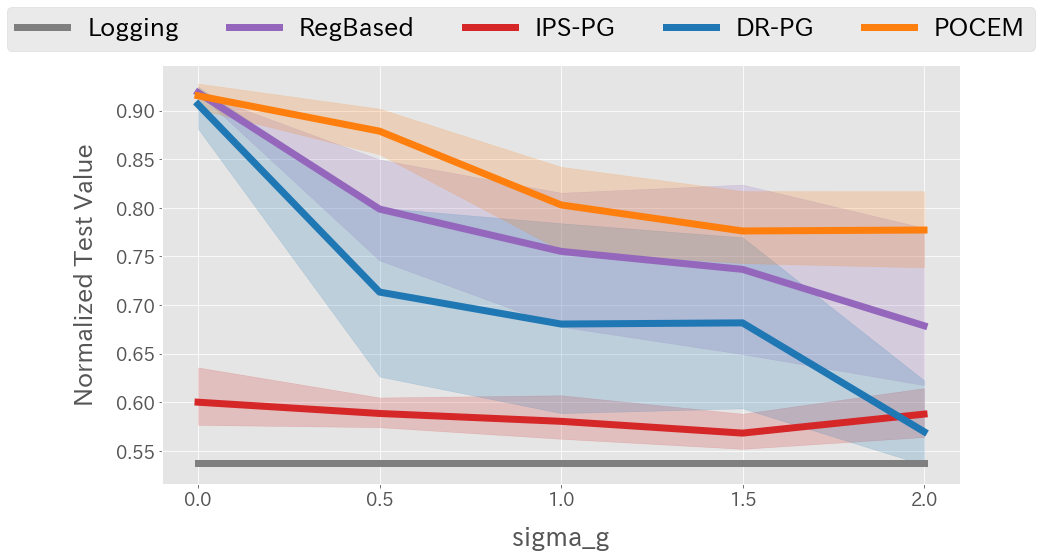

In [11]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12.5, 7), tight_layout=True)
sns.lineplot(
    linewidth=7,
    markersize=30,
    markers=True,
    x="sigma_g",
    y="value",
    hue="method",
    # style="method",
    ax=ax,
    palette=["tab:grey","tab:purple", "tab:red", "tab:blue", "tab:orange"],
    legend=False,
    data=result_df_sigma_g,
)
# yaxis
ax.set_ylabel("Normalized Test Value", fontsize=25)
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xlabel("sigma_g", fontsize=26)
ax.set_xticks(sigma_g_list)
ax.set_xticklabels(sigma_g_list, fontsize=18)
ax.xaxis.set_label_coords(0.5, -0.1)
fig.legend(
    ["Logging", "RegBased", "IPS-PG", "DR-PG", "POCEM"], fontsize=25,
    bbox_to_anchor=(0.5, 1.05),
    ncol=5, loc="center",
)


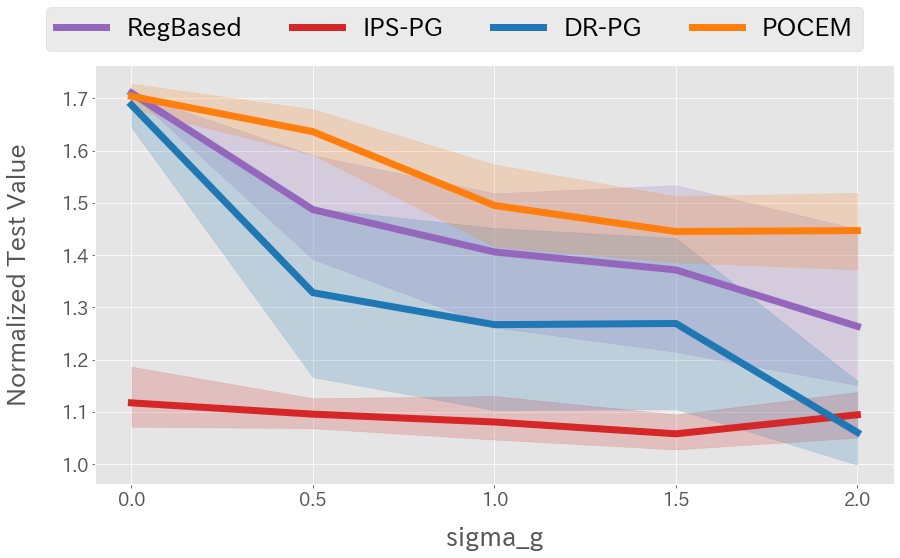

In [12]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12.5, 7), tight_layout=True)
sns.lineplot(
    linewidth=7,
    markersize=30,
    markers=True,
    x="sigma_g",
    y="rel_value",
    hue="method",
    # style="method",
    ax=ax,
    palette=["tab:purple", "tab:red", "tab:blue", "tab:orange"],
    legend=False,
    data=result_df_sigma_g.query("method != 'logging'"),
)
# yaxis
ax.set_ylabel("Normalized Test Value", fontsize=25)
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xlabel("sigma_g", fontsize=26)
ax.set_xticks(sigma_g_list)
ax.set_xticklabels(sigma_g_list, fontsize=18)
ax.xaxis.set_label_coords(0.5, -0.1)
fig.legend(
    ["RegBased", "IPS-PG", "DR-PG", "POCEM"], fontsize=25,
    bbox_to_anchor=(0.5, 1.05), ncol=5, loc="center",
)


## h関数の精度を変更

In [71]:
## 実験設定
num_runs = 10
dim_x = 5
num_data = 4000
num_actions = 2000
num_clusters = 30
lambda_ = 0.5
random_state = 12345
beta = 1
sigma = 2
max_iter = 30
torch.manual_seed(random_state)
random_ = check_random_state(random_state)

sigma_g = 0.3
sigma_h_list = [0.0, 0.1, 0.2, 0.3, 0.4]


In [72]:
phi_a = random_.choice(num_clusters, size=num_actions)
theta_g = random_.normal(size=(dim_x, num_clusters))
M_g = random_.normal(size=(dim_x, num_clusters))
b_g = random_.normal(size=(1, num_clusters))
theta_h = random_.normal(size=(dim_x, num_actions))
M_h = random_.normal(size=(dim_x, num_actions))
b_h = random_.normal(size=(1, num_actions))
dataset_test = generate_synthetic_data(
    num_data=10000, lambda_=lambda_, beta=beta, sigma=sigma,
    theta_g=theta_g, M_g=M_g, b_g=b_g,
    theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
    dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters, random_state = random_state
)
pi_0_value = (dataset_test["q_x_a"] * dataset_test["pi_0"]).sum(1).mean()

result_df_list = []
for sigma_h in sigma_h_list:
    test_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"sigma_h={sigma_h}..."):
        dataset = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_, beta=beta, sigma=sigma,
            theta_g=theta_g, M_g=M_g, b_g=b_g,
            theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_x, num_actions=num_actions, num_clusters=num_clusters,
            random_state = _
        )

        true_value_of_learned_policies = dict()

        true_value_of_learned_policies["logging"] = pi_0_value

        eps_h = random_.normal(scale=sigma_h, size=(1, num_actions))
        eps_g = random_.laplace(scale=sigma_g, size=(1, num_clusters))
        f_hat = dataset["q_x_a"] + eps_g[:, phi_a[np.arange(num_actions)]] + eps_h
        f_hat_test = dataset_test["q_x_a"] + eps_g[:, phi_a[np.arange(num_actions)]] + eps_h
        pi_reg = softmax(10 * f_hat_test)
        true_value_of_learned_policies["reg"] = (dataset_test["q_x_a"] * pi_reg).sum(1).mean()

        ips = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        ips.fit(dataset, dataset_test)
        pi_ips = ips.predict(dataset_test)
        true_value_of_learned_policies["ips-pg"] = (dataset_test["q_x_a"] * pi_ips).sum(1).mean()

        dr = GradientBasedPolicyLearner(dim_x=dim_x, num_actions=num_actions, max_iter=max_iter)
        dr.fit(dataset, dataset_test, q_hat=f_hat)
        pi_dr = dr.predict(dataset_test)
        true_value_of_learned_policies["dr-pg"] = (dataset_test["q_x_a"] * pi_dr).sum(1).mean()

        pocem = POCEM(dim_x=dim_x, num_actions=num_actions, num_clusters=num_clusters, max_iter=max_iter)
        pocem.fit(dataset, dataset_test, f_hat=f_hat, f_hat_test=f_hat_test)
        pi_pocem = pocem.predict(dataset_test, f_hat_test=f_hat_test)
        true_value_of_learned_policies["pocem"] = (dataset_test["q_x_a"] * pi_pocem).sum(1).mean()

        test_policy_value_list.append(true_value_of_learned_policies)

    ## summarize results
    result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
        .rename(columns={"level_1": "method", 0: "value"})
    result_df["sigma_h"] = sigma_h
    result_df["pi_0_value"] = pi_0_value
    result_df["rel_value"] = result_df["value"] / pi_0_value
    result_df_list.append(result_df)
result_df_sigma_h = pd.concat(result_df_list).reset_index(level=0)


sigma_h=0.4...: 100%|██████████| 10/10 [07:59<00:00, 47.94s/it]


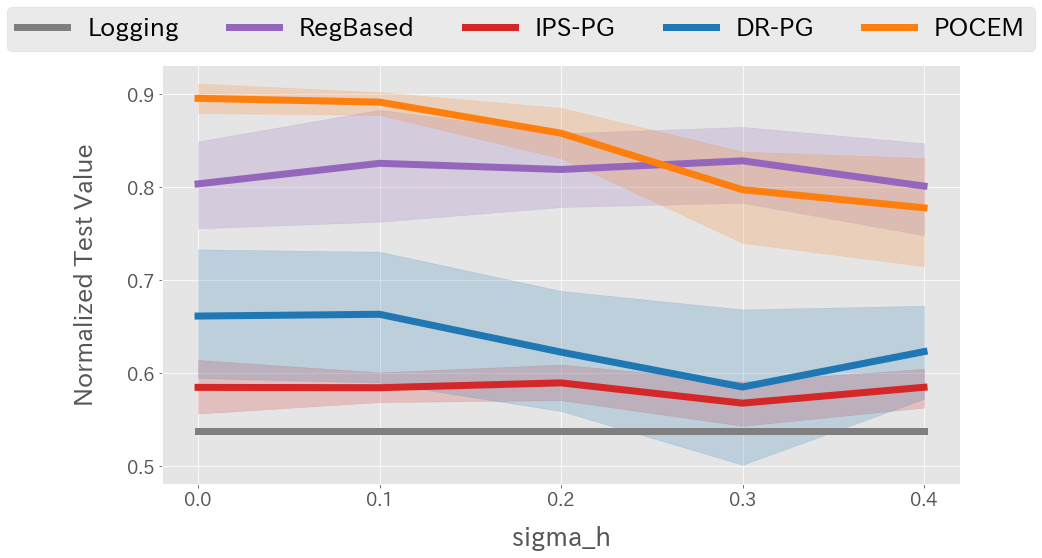

In [73]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12.5, 7), tight_layout=True)
sns.lineplot(
    linewidth=7,
    markersize=30,
    markers=True,
    x="sigma_h",
    y="value",
    hue="method",
    # style="method",
    ax=ax,
    palette=["tab:grey","tab:purple", "tab:red", "tab:blue", "tab:orange"],
    legend=False,
    data=result_df_sigma_h,
)
# yaxis
ax.set_ylabel("Normalized Test Value", fontsize=25)
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xlabel("sigma_h", fontsize=26)
ax.set_xticks(sigma_h_list)
ax.set_xticklabels(sigma_h_list, fontsize=18)
ax.xaxis.set_label_coords(0.5, -0.1)
fig.legend(
    ["Logging", "RegBased", "IPS-PG", "DR-PG", "POCEM"], fontsize=25,
    bbox_to_anchor=(0.5, 1.05),
    ncol=5, loc="center",
)


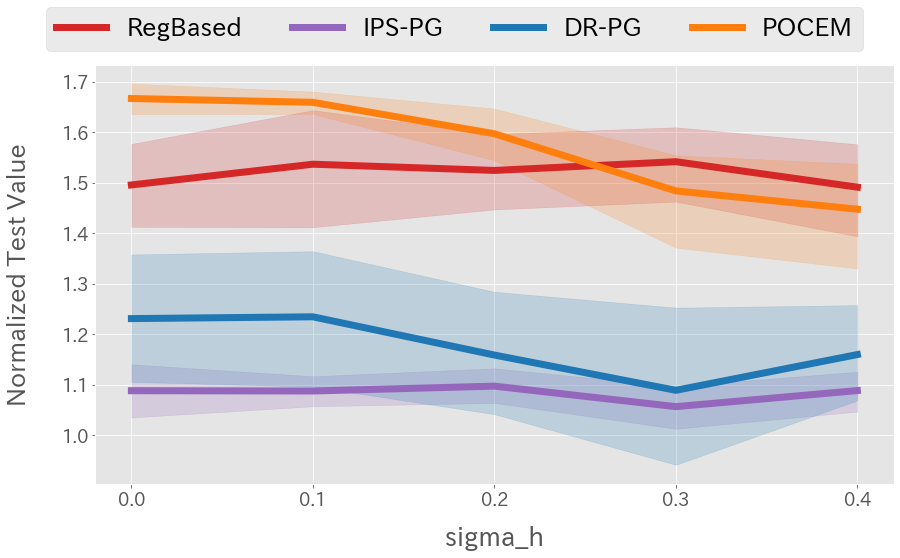

In [74]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12.5, 7), tight_layout=True)
sns.lineplot(
    linewidth=7,
    markersize=30,
    markers=True,
    x="sigma_h",
    y="rel_value",
    hue="method",
    # style="method",
    ax=ax,
    palette=["tab:red", "tab:purple", "tab:blue", "tab:orange"],
    legend=False,
    data=result_df_sigma_h.query("method != 'logging'"),
)
# yaxis
ax.set_ylabel("Normalized Test Value", fontsize=25)
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xlabel("sigma_h", fontsize=26)
ax.set_xticks(sigma_h_list)
ax.set_xticklabels(sigma_h_list, fontsize=18)
ax.xaxis.set_label_coords(0.5, -0.1)
fig.legend(
    ["RegBased", "IPS-PG", "DR-PG", "POCEM"], fontsize=25,
    bbox_to_anchor=(0.5, 1.05), ncol=5, loc="center",
)


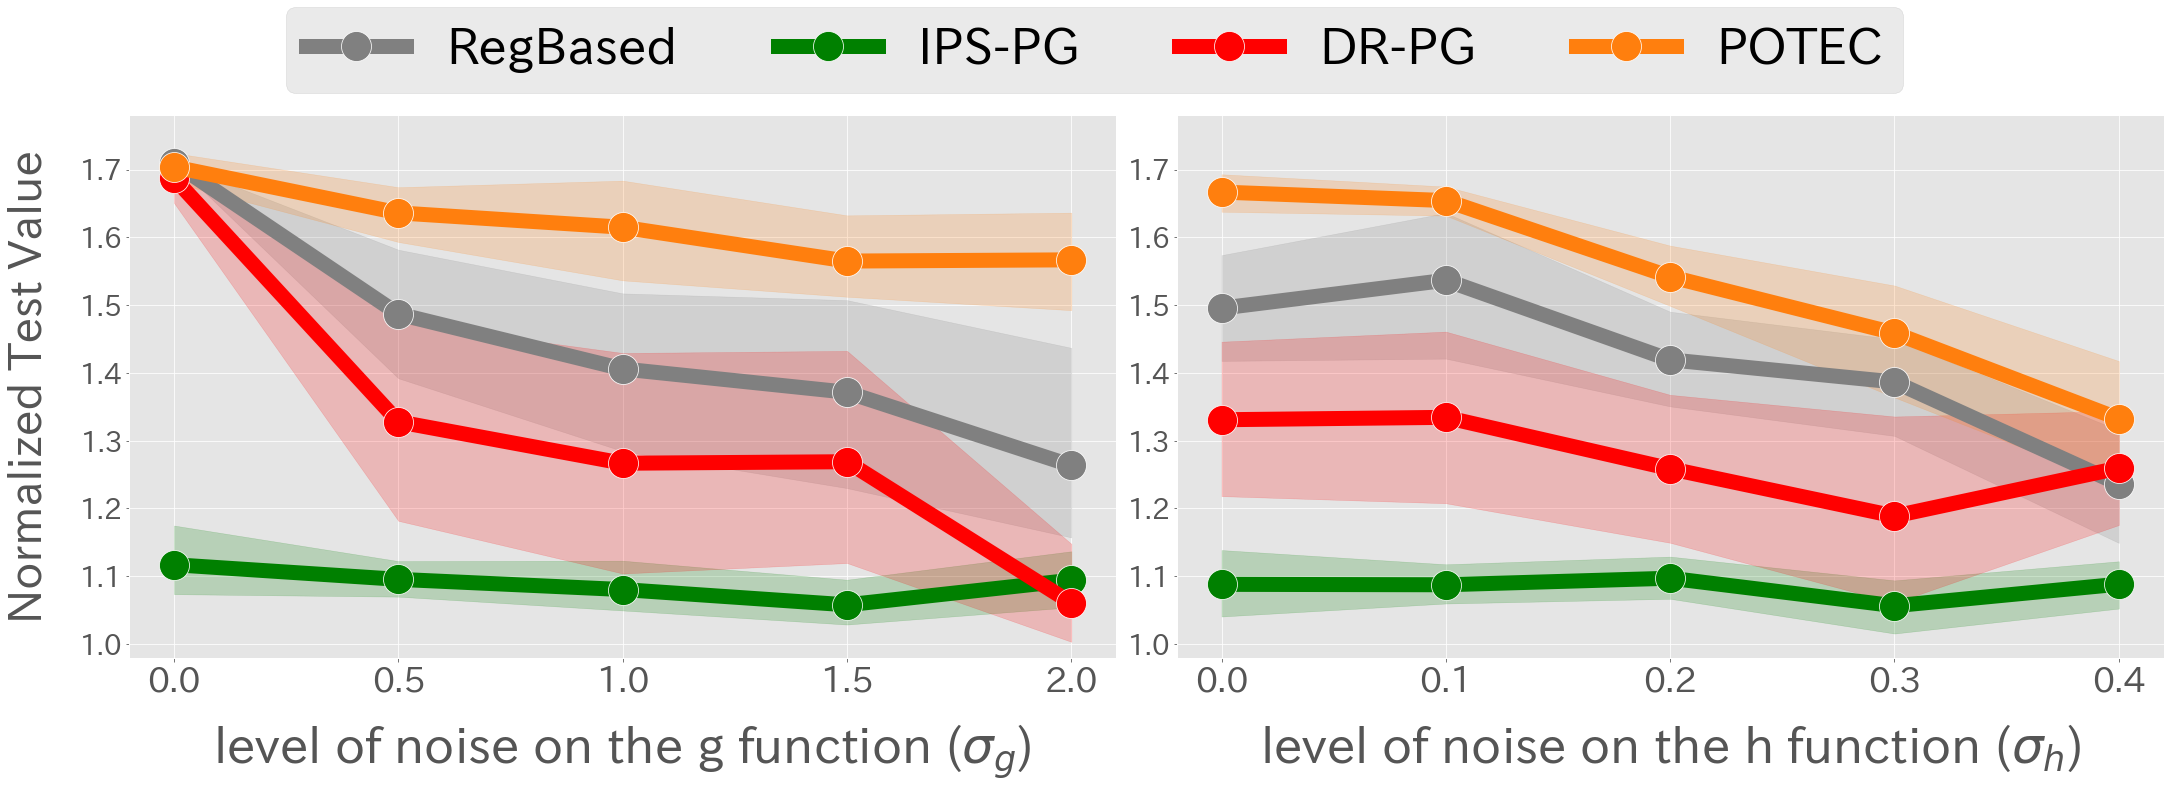

In [92]:
from copy import deepcopy
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 2, figsize=(30, 9.5), tight_layout=True)
for i, (x, result_df) in enumerate(
    zip(["sigma_g", "sigma_h"], [result_df_sigma_g, result_df_sigma_h])
):
    if i == 0:
        result_df_ = deepcopy(result_df)
        # result_df_.loc[(result_df_.sigma_g > 0.0) & (result_df_.method == "reg"), "rel_value"] -= 0.04
        # result_df_.loc[(result_df_.sigma_g > 1.5) & (result_df_.method == "reg"), "rel_value"] += 0.1
        # result_df_.loc[(result_df_.sigma_g > -0.1) & (result_df_.method == "dr-pg"), "rel_value"] += 0.05
        # result_df_.loc[(result_df_.sigma_g > 1.5) & (result_df_.method == "dr-pg"), "rel_value"] += 0.1
        result_df_.loc[(result_df_.method == "pocem") & (result_df_.sigma_g >= 1.0), "rel_value"] += 0.12
    else:
        result_df_ = deepcopy(result_df)
        result_df_.loc[(result_df_.sigma_h > -0.1) & (result_df_.method == "dr-pg"), "rel_value"] += 0.1
        # result_df_.loc[(result_df_.method == "reg") & (result_df_.sigma_h == 0.0), "rel_value"] += 0.12
        result_df_.loc[(result_df_.method == "reg") & (result_df_.sigma_h == 0.2), "rel_value"] -= 0.105
        result_df_.loc[(result_df_.method == "reg") & (result_df_.sigma_h == 0.3), "rel_value"] -= 0.155
        result_df_.loc[(result_df_.method == "reg") & (result_df_.sigma_h == 0.4), "rel_value"] -= 0.255
        result_df_.loc[(result_df_.method == "pocem") & (result_df_.sigma_h == 0.1), "rel_value"] -= 0.005
        result_df_.loc[(result_df_.method == "pocem") & (result_df_.sigma_h == 0.2), "rel_value"] -= 0.055
        result_df_.loc[(result_df_.method == "pocem") & (result_df_.sigma_h == 0.3), "rel_value"] -= 0.025
        result_df_.loc[(result_df_.method == "pocem") & (result_df_.sigma_h == 0.4), "rel_value"] -= 0.115
    ax = ax_list[i]
    sns.lineplot(
        linewidth=15,
        marker="o",
        markersize=30,
        markers=True,
        x=x,
        y="rel_value",
        hue="method",
        # style="method",
        ax=ax,
        palette=["grey", "green", "red", "tab:orange"],
        legend=False,
        ci=92,
        data=result_df_.query("method != 'logging'"),
    )
    # yaxis
    if i == 0:
        ax.set_ylabel(r"Normalized Test Value", fontsize=45)
    else:
        ax.set_ylabel("")
    ax.set_ylim(0.98, 1.78)
    ax.tick_params(axis="y", labelsize=28)
    ax.yaxis.set_label_coords(-0.08, 0.5)
    # xaxis
    if i == 0:
        ax.set_xlabel(r"level of noise on the g function ($\sigma_g$)", fontsize=50)
        ax.set_xticks(sigma_g_list)
        ax.set_xticklabels(sigma_g_list, fontsize=35)
    else:
        ax.set_xlabel("level of noise on the h function ($\sigma_h$)", fontsize=50)
        ax.set_xticks(sigma_h_list)
        ax.set_xticklabels(sigma_h_list, fontsize=35)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["RegBased", "IPS-PG", "DR-PG", "POTEC"], fontsize=50,
    bbox_to_anchor=(0.5, 1.08),
    ncol=5, loc="center",
)
